<a href="https://colab.research.google.com/github/lastinm/ml_hw_notebooks/blob/main/%D0%A5%D1%80%D0%B0%D0%BD%D0%B5%D0%BD%D0%B8%D0%B5%2C_%D0%B8%D0%B7%D0%B2%D0%BB%D0%B5%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%B8_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B8%D1%85_%D0%B4%D0%B0%D0%BD%D0%BD%D1%8B%D1%85_%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_%E2%84%966.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Блок 1. Исходные данные

## 1. Найти (сгенерировать) набор данных, подходящий для выполнения всех заданий.

In [1]:
# импорт необходимых библиотек
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import pandas as pd

In [2]:
# Создаем Spark-сессию
spark = SparkSession.builder \
    .appName("Iris Dataset Analysis") \
    .getOrCreate()

## 2. Считать данные в датафрейм

In [3]:
# Загрузка набора данных Titanic
# Если нет файла, то скачиваем его с GitHub по ссылке
import os

if not os.path.exists("/content/titanic.csv"):
  !wget https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

In [4]:
titanic_df = spark.read.csv("/content/titanic.csv", header=True, inferSchema=True)

# Показать первые 5 строк
titanic_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

## 3. Проверить типы, выполнить преобразования типов, если это требуется.

In [5]:
# Проверка типов данных
titanic_df.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [6]:
# Кодирование категориальных признаков. Преобразование текстовых данных в числовые:
from pyspark.ml.feature import StringIndexer

# Кодирование столбца 'Sex'
sex_indexer = StringIndexer(inputCol="Sex", outputCol="Sex_Index")
titanic_df = sex_indexer.fit(titanic_df).transform(titanic_df)

## 4. Провести предварительную обработку (все пункты должны быть выполнены):

* Правило для одной колонки: расчет и замена средним по колонке.

In [7]:
# Подсчет количества пропущенных значений в колонке 'Age'
missing_age_count = titanic_df.filter(titanic_df.Age.isNull()).count()

# Общее количество строк
total_count = titanic_df.count()
print(f"Общее количество строк: {total_count}")

# Вывод количества пропущенных значений
print(f"Количество пропущенных значений в колонке 'Age': {missing_age_count}")

Общее количество строк: 891
Количество пропущенных значений в колонке 'Age': 177


In [8]:
# Шаг 1: Рассчитать среднее значение 'Age'
mean_age = titanic_df.select(F.mean(F.col("Age"))).first()[0]

# Шаг 2: Заменить пропущенные значения на среднее
titanic_df = titanic_df.na.fill({"Age": mean_age})

# Теперь можно посмотреть обновленные данные
titanic_df.show()

+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+-----+--------+---------+
|PassengerId|Survived|Pclass|                Name|   Sex|              Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Sex_Index|
+-----------+--------+------+--------------------+------+-----------------+-----+-----+----------------+-------+-----+--------+---------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|             22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|      0.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|             38.0|    1|    0|        PC 17599|71.2833|  C85|       C|      1.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|             26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|      1.0|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|             35.0|    1|    0|          113803|   53.1| C123|       S|      1.0|
|          5|       0|     3|Allen

* Правило для другой колонки: удалить колонку с отсутствующими значениями.

In [9]:
# Подсчет количества пропущенных значений в колонке 'Age'
missing_age_count = titanic_df.filter(titanic_df.Cabin.isNull()).count()
missing_age_count

687

In [10]:
# Удалим полность колонку Cabin, т.к. в ней многие значения в ней отсутствуют,
# и она содержит много уникальных значений.
titanic_df = titanic_df.drop("Cabin")
titanic_df.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+---------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Embarked|Sex_Index|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+--------+---------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25|       S|      0.0|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|       C|      1.0|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925|       S|      1.0|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1|       S|      1.0|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05|       S|      0.0|
+-----------+--------+------+-------------------

* Правило для другой колонки: удалить строки с отсутствующими значениями.

In [11]:
# Подсчет количества пропущенных значений в колонке 'Embarked'
missing_age_count = titanic_df.filter(titanic_df.Embarked.isNull()).count()
missing_age_count

2

In [12]:
# Удаление строк с пропусками
titanic_df = titanic_df.filter(titanic_df.Embarked.isNotNull())

In [13]:
# Кодирование столбца 'Embarked'
embarked_indexer = StringIndexer(inputCol="Embarked", outputCol="Embarked_Index")
titanic_df = embarked_indexer.fit(titanic_df).transform(titanic_df)

* Удалить дубликаты строк.

In [14]:
# Общее количество строк
print(f"Общее количество строк до удаления дубликатов: {titanic_df.count()}")

titanic_df = titanic_df.dropDuplicates()

# Количество строк после удаления дубликатов
print(f"Количество строк после удаления дубликатов: {titanic_df.count()}")

Общее количество строк до удаления дубликатов: 889
Количество строк после удаления дубликатов: 889


# Блок 2. Базовые запросы

1. Выполнить фильтрацию по данным.

In [15]:
# К примеру, оберем всех пассажиров женского пола моложе 18 лет.
titanic_df.filter("Age < 18 and Sex_Index = 1").show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------+------+--------+---------+--------------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|    Ticket|  Fare|Embarked|Sex_Index|Embarked_Index|
+-----------+--------+------+--------------------+------+----+-----+-----+----------+------+--------+---------+--------------+
|        308|       1|     1|Penasco y Castell...|female|17.0|    1|    0|  PC 17758| 108.9|       C|      1.0|           1.0|
|        542|       0|     3|Andersson, Miss. ...|female| 9.0|    4|    2|    347082|31.275|       S|      1.0|           0.0|
|         85|       1|     2| Ilett, Miss. Bertha|female|17.0|    0|    0|SO/C 14885|  10.5|       S|      1.0|           0.0|
|        778|       1|     3|Emanuel, Miss. Vi...|female| 5.0|    0|    0|    364516|12.475|       S|      1.0|           0.0|
|         11|       1|     3|Sandstrom, Miss. ...|female| 4.0|    1|    1|   PP 9549|  16.7|       S|      1.0|

2. Выполнить 2-3 группировки данных, с расчетом агрегированных значений (среднее, максимум, минимум).

In [16]:
# Пример 1: Группировка по полу с расчетом средней, максимальной и минимальной стоимости билета
gender_agg = titanic_df.groupBy("Sex_Index") \
    .agg(
        F.avg("Fare").alias("Average_Fare"),
        F.max("Fare").alias("Max_Fare"),
        F.min("Fare").alias("Min_Fare")
    )
print("Агрегация по полу:")
gender_agg.show()

Агрегация по полу:
+---------+------------------+--------+--------+
|Sex_Index|      Average_Fare|Max_Fare|Min_Fare|
+---------+------------------+--------+--------+
|      0.0|25.523893414211404|512.3292|     0.0|
|      1.0| 44.25212435897435|512.3292|    6.75|
+---------+------------------+--------+--------+



In [17]:
# Пример 2: Группировка по классу пассажиров с расчетом средней, максимальной и минимальной стоимости билета
class_agg = titanic_df.groupBy("Pclass") \
    .agg(
        F.avg("Age").alias("Average_Age"),
        F.max("Age").alias("Max_Age"),
        F.min("Age").alias("Min_Age")
    )
print("Агрегация по классу пассажиров:")
class_agg.show()

Агрегация по классу пассажиров:
+------+------------------+-------+-------+
|Pclass|       Average_Age|Max_Age|Min_Age|
+------+------------------+-------+-------+
|     1| 36.92707256734471|   80.0|   0.92|
|     3|26.403258655804446|   74.0|   0.42|
|     2|29.866958120204607|   70.0|   0.67|
+------+------------------+-------+-------+



In [18]:
# Пример 3: Группировка по классу и полу с расчетом средней стоимости билета
gender_class_agg = titanic_df.groupBy("Pclass", "Sex") \
    .agg(
        F.avg("Fare").alias("Average_Fare"),
        F.count("PassengerId").alias("Count")
    ) \
    .orderBy("Pclass", "Count")  # Сортировка по классу и количеству пассажиров

print("Агрегация по полу и классу пассажиров:")
gender_class_agg.show()

Агрегация по полу и классу пассажиров:
+------+------+------------------+-----+
|Pclass|   Sex|      Average_Fare|Count|
+------+------+------------------+-----+
|     1|female|106.69374999999997|   92|
|     1|  male| 67.22612704918032|  122|
|     2|female|21.970121052631576|   76|
|     2|  male| 19.74178240740741|  108|
|     3|female|16.118809722222224|  144|
|     3|  male| 12.66163256484151|  347|
+------+------+------------------+-----+



# Блок 3. Анализ числовых данных

1. Рассчитать числовые характеристики, включая асимметрию и эксцесс для числовых колонок.

In [19]:
# Выбор числовых столбцов для анализа
numeric_columns = ["Age", "Fare"]  # Пример числовых колонок

# Вычисление асимметрии и эксцесса для числовых колонок
numerical_stats = titanic_df.select(
    [F.skewness(col).alias(f"{col}_skewness") for col in numeric_columns] +
    [F.kurtosis(col).alias(f"{col}_kurtosis") for col in numeric_columns]
)

# Вывод результатов
print("Числовые характеристики (асимметрия и эксцесс):")
numerical_stats.show()

Числовые характеристики (асимметрия и эксцесс):
+------------------+-----------------+------------------+-----------------+
|      Age_skewness|    Fare_skewness|      Age_kurtosis|    Fare_kurtosis|
+------------------+-----------------+------------------+-----------------+
|0.4309914863386597|4.793334993307852|0.9667674130563486|33.31357062160459|
+------------------+-----------------+------------------+-----------------+



2. Посчитайте матрицу корреляции для числовых признаков.

In [20]:
# Выбор только нужных столбцов
titanic_selected_df = titanic_df.select("Age", "Fare")

# Вычисление коэффициента корреляции
age_fare_corr = titanic_selected_df.stat.corr("Age", "Fare")
print(f"Коэффициент корреляции между 'Age' и 'Fare': {age_fare_corr}")

Коэффициент корреляции между 'Age' и 'Fare': 0.08860447322905159


3. Постройте визуализацию полученных расчетов.

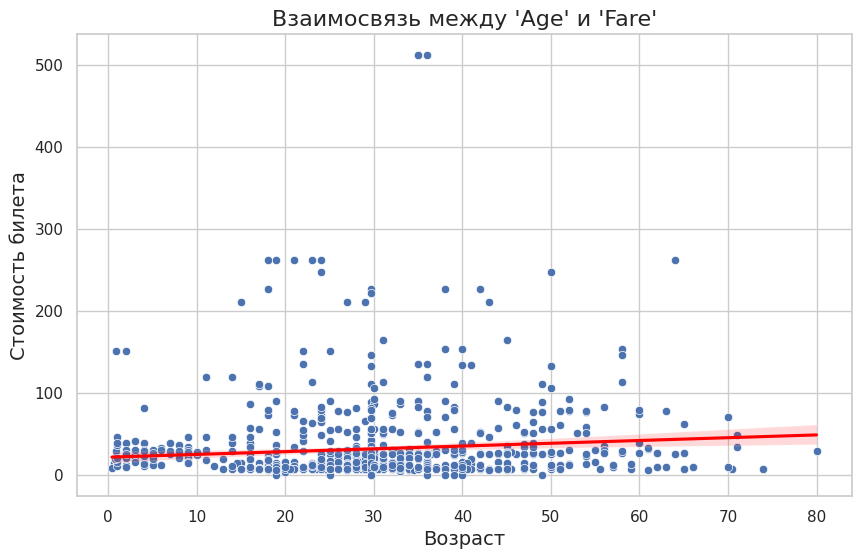

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Переводим DataFrame PySpark в DataFrame Pandas
titanic_df_pandas = titanic_df.toPandas()

# Настройка стиля графика
sns.set(style="whitegrid")

# Создание рассеянного графика
plt.figure(figsize=(10, 6))
sns.scatterplot(data=titanic_df_pandas, x="Age", y="Fare")

# Добавление линии регрессии
sns.regplot(data=titanic_df_pandas, x="Age", y="Fare", scatter=False, color='red')

# Настройка заголовка и меток осей
plt.title("Взаимосвязь между 'Age' и 'Fare'", fontsize=16)
plt.xlabel("Возраст", fontsize=14)
plt.ylabel("Стоимость билета", fontsize=14)

# Показ графика
plt.show()

# Блок 4. Анализ категориальных данных

1. Рассчитайте стандартные характеристики для категориальных колонок (частота, процент от общего числа).

In [22]:
# Подсчет частоты для колонки 'Embarked'
embarked_counts = titanic_df.groupBy("Embarked").agg(
    F.count("Embarked").alias("Frequency")
)

# Подсчет доли от общего числа для 'Embarked'
total_count = titanic_df.count()
embarked_percent = embarked_counts.withColumn("Percentage", (F.col("Frequency") / total_count) * 100)

# Отображение результатов для 'Embarked'
embarked_percent.show()

# Подсчет частоты для колонки 'Sex'
sex_counts = titanic_df.groupBy("Sex").agg(
    F.count("Sex").alias("Frequency")
)

# Подсчет доли от общего числа для 'Sex'
sex_percent = sex_counts.withColumn("Percentage", (F.col("Frequency") / total_count) * 100)

# Отображение результатов для 'Sex'
sex_percent.show()

+--------+---------+-----------------+
|Embarked|Frequency|       Percentage|
+--------+---------+-----------------+
|       Q|       77|8.661417322834646|
|       C|      168|18.89763779527559|
|       S|      644|72.44094488188976|
+--------+---------+-----------------+

+------+---------+-----------------+
|   Sex|Frequency|       Percentage|
+------+---------+-----------------+
|female|      312|35.09561304836895|
|  male|      577|64.90438695163104|
+------+---------+-----------------+



2. Постройте визуализацию полученных расчетов.

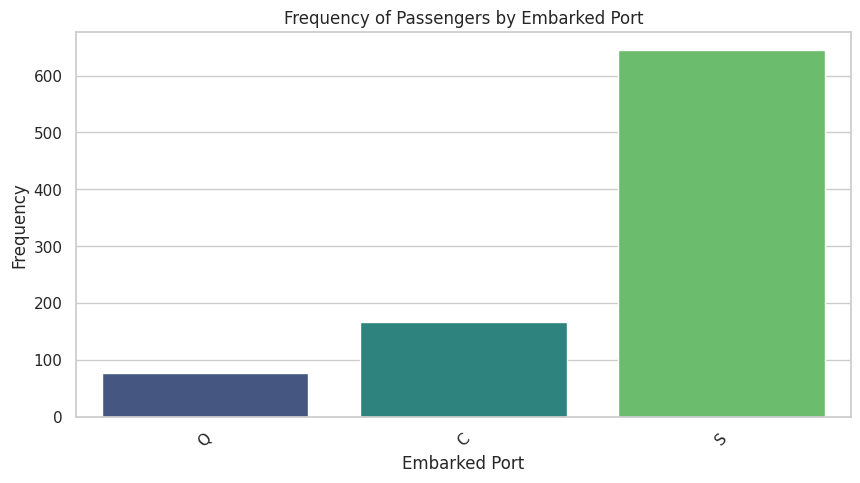

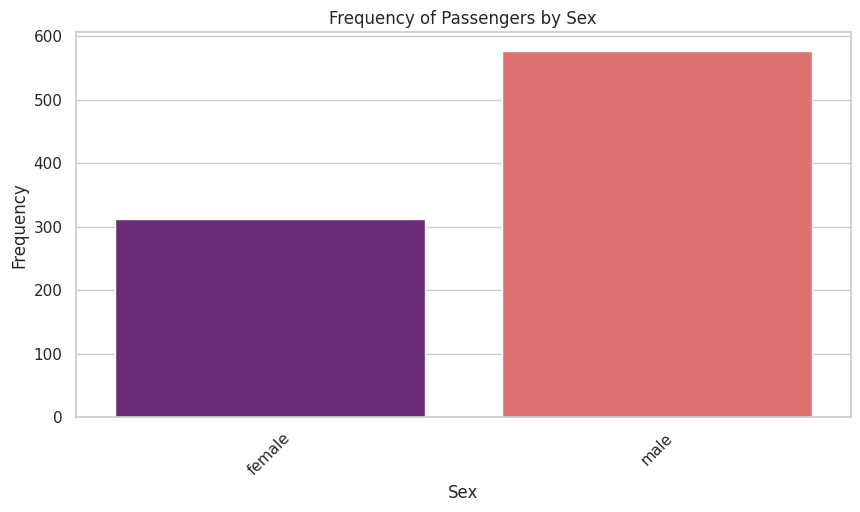

In [23]:
# Преобразование результатов в Pandas DataFrame
embarked_df = embarked_percent.toPandas()
sex_df = sex_percent.toPandas()

# Визуализация для 'Embarked'
plt.figure(figsize=(10, 5))
sns.barplot(data=embarked_df, x='Embarked', y='Frequency', hue='Embarked', palette='viridis', legend=False)
plt.title('Frequency of Passengers by Embarked Port')
plt.xlabel('Embarked Port')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Визуализация для 'Sex_Index'
plt.figure(figsize=(10, 5))
sns.barplot(data=sex_df, x='Sex', y='Frequency', hue='Sex', palette='magma', legend=False)
plt.title('Frequency of Passengers by Sex')
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Блок 5. Применение ML

In [24]:
# VectorAssembler: Эта функция объединяет несколько колонок в одну, создавая вектор признаков,
# что является обязательным шагом перед обучением модели.
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [25]:
# Удаление оригинального столбца 'Sex'
#titanic_df = titanic_df.drop("Sex")

# Теперь вы можете посмотреть результат
#titanic_df.show(5)

In [26]:
# Шаг 4: Применение VectorAssembler для создания вектора признаков
assembler = VectorAssembler(
    inputCols=["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_Index", "Embarked_Index"],
    outputCol="features"
)

final_df = assembler.transform(titanic_df)

# Шаг 5: Показ результата
final_df.select("PassengerId", "Survived", "features").show(truncate=False)

+-----------+--------+--------------------------------------------+
|PassengerId|Survived|features                                    |
+-----------+--------+--------------------------------------------+
|31         |0       |[1.0,40.0,0.0,0.0,27.7208,0.0,1.0]          |
|90         |0       |(7,[0,1,4],[3.0,24.0,8.05])                 |
|294        |0       |[3.0,24.0,0.0,0.0,8.85,1.0,0.0]             |
|594        |0       |[3.0,29.69911764705882,0.0,2.0,7.75,1.0,2.0]|
|633        |1       |[1.0,32.0,0.0,0.0,30.5,0.0,1.0]             |
|682        |1       |[1.0,27.0,0.0,0.0,76.7292,0.0,1.0]          |
|704        |0       |[3.0,25.0,0.0,0.0,7.7417,0.0,2.0]           |
|137        |1       |[1.0,19.0,0.0,2.0,26.2833,1.0,0.0]          |
|142        |1       |[3.0,22.0,0.0,0.0,7.75,1.0,0.0]             |
|159        |0       |(7,[0,1,4],[3.0,29.69911764705882,8.6625])  |
|225        |1       |[1.0,38.0,1.0,0.0,90.0,0.0,0.0]             |
|444        |1       |[2.0,28.0,0.0,0.0,13.0,1.0

In [30]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [31]:
# Инициализация индексаторов и кодировщиков
indexer_sex = StringIndexer(inputCol="Sex", outputCol="SexIndex")
indexer_embarked = StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndex")
encoder_sex = OneHotEncoder(inputCols=["SexIndex"], outputCols=["SexVec"])
encoder_embarked = OneHotEncoder(inputCols=["EmbarkedIndex"], outputCols=["EmbarkedVec"])

# Сборка вектора признаков
assembler = VectorAssembler(inputCols=["Pclass", "Age", "SibSp", "Parch", "Fare", "SexVec", "EmbarkedVec"], outputCol="features")

# Логистическая регрессия
lr = LogisticRegression(featuresCol="features", labelCol="Survived")

# Создание пайплайна
pipeline = Pipeline(stages=[indexer_sex, indexer_embarked, encoder_sex, encoder_embarked, assembler, lr])

# Обучение модели
model = pipeline.fit(titanic_df)

# Оценка модели
predictions = model.transform(titanic_df)
evaluator = BinaryClassificationEvaluator(labelCol="Survived")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8573047251687563


In [32]:
# Остановка SparkSession
spark.stop()